In [2]:
D.<x> = PolynomialRing(QQ)
R = PolynomialRing(QQ,'x')
S = PowerSeriesRing(QQ,'x', default_prec=300)
L=LaurentSeriesRing(QQ,'x', default_prec=300)
#S.<x,y>=PowerSeriesRing(QQ,default_prec=300)
# Using "R = PolynomialRing(QQ,'x')" produces an error.
# Yet using S as defined here is fine (see definition of Fraleigh4 below)
# But S = PowerSeriesRing(QQ,'x','y') also produces an error.
Scplx= PowerSeriesRing(CC,'x',default_prec=300)
def pochhammer(x,n):
    return product ([x+k for k in [0..n-1]])
def cRaleigh2(alpha,beta,nu):
    pchhmrA = pochhammer(alpha,nu)
    pchhmrB = pochhammer(beta,nu)
    fnu=factorial(nu)
    answer = D(pchhmrA*pchhmrB/fnu^2)
    return answer
def term(alpha,beta,p):
    return D(1/(alpha + p) + 1/(beta + p) - 2/(1 + p))
def eRaleigh(alpha, beta, nu):
    return D(sum([term(alpha, beta, p) for p in [0..nu - 1]]))
def FstarRaleigh2(alpha,beta,u,terms):
    fsr = sum([cRaleigh2(alpha, beta, nu)*eRaleigh(alpha,beta,nu)*u^nu for nu in [1..terms]])
    return D(fsr)
def Fraleigh2(alpha,beta,u,terms): 
    return D(sum([cRaleigh2(alpha,beta,nu)*u^nu for nu in [0..terms]]))
def FstarRaleigh3(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fsr2 = FstarRaleigh2(alpha,beta,x,n)
    return D(fsr2)
def Fraleigh4(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fr2 = Fraleigh2(alpha,beta,x,n)
    return D(fr2)
def exNo3c(n,m):
    a1 = S(x)*exp(S(FstarRaleigh3(n,m,x)/Fraleigh4(n,m,x))).O(2*n)
    # S(x) instead of x in df of a1 to avoid an error message
    # after use of the stripQuotationMarks command below.
    a2 = S(a1).O(n+1)
    return a2 # applying S to argument of exp is key.
def J(n,m):
    exn = exNo3c(n+2,m)
    jnm = 1/exn.reverse()
    return jnm.O(n+1) # Jtest is faster than J, and they agree.
def normalJ(n,m):
    f = J(n,m)
    return f.truncate(n+1)
def Jcoefficient(n,m):
    f = J(n+2,m)
    f1 = f.truncate(n+1)
    f1=f1.list()
    f1=Set(f1)
    g1 = f.truncate(n)
    g1 = g1.list()
    g1 = set(g1)
    h = f1.difference(g1)
    h = h.list()
    return h[0]
def xjNewStep(n,m): 
    f=J(n,m)
    fl=f.list()
    return (sum(c*x**i*(m**3*2**6)**i for i,c in enumerate(fl)))
def xjNew(n,m):
    return xjNewStep(n-1,m)
def xjNewCoefficient(n,m):
    if n>0:return (xjNew(n,m)-xjNew(n-1,m))/x^n
    if n==0:return 1
def xjNewTest(n,m):
    return D(xjNewStep(n-1,m))
def j(n,m):return xjNew(n,m)/x

def H4(n,m):
    jay=J(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-1)
    return ((S(numerator/denominator)^(1/(m-2))).O(n+1)).polynomial()
    #if argument is an S type then 'polynomial' takes no argument.

def H4strike(n,m): 
    poly=H4(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer


def H6(n,m):
    def base6(n,m):
        jay=J(n+1,m)
        num=(x*derivative(jay,x))^m # chain rule; variable is tau not x.
        den = expand(jay^(m-1)*(jay-1))
        return L((-1)^m*(num/den)).O(n+1)
    return S(base6(n,m)^(1/(m-2))).polynomial()
     #if argument is an S type then 'polynomial' takes no argument.

def H6strike(n,m): 
    poly=H6(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer

def polynomialCoefficient(n,poly):
    return poly.list()[n]
def factorpairToFactor(factorpair):
    (monomial,exponent)=factorpair
    return monomial^exponent
def numericalfactor(polynomial):
    fp=polynomial.factor()
    lst=[factorpairToFactor(factorpair) for factorpair in fp]
    return polynomial/product(lst)
def lastfactor(polynomial):
    fp=polynomial.factor()
    fp=FiniteEnumeratedSet(fp)
    return factorpairToFactor(fp.last())
def reduced(polynomial):
    return numericalfactor(polynomial)*lastfactor(polynomial)
def stripQuotationMarks(string):
    var('x')
    return sage_eval(string,locals={'x':x})
def nieburTau(n):
# The contortions below sidestep mysterious (to me) error messages...
# nieburTau is an algorith for Ramanujan''s tau from the paper
# "A formula for Ramanujan's tau-function" by Douglas Niebur.
# (He spells tau with the Greek letter.)
    def step1(n,k):
        return 35*k^4-52*k^3*n+18*k^2*n^2
    def step2(n,k):
        return sigma(k)*sigma(n-k)
    def step3(n):
        ans=0
        for k in [1..n-1]:
            ans=ans+step1(n,k)*step2(n,k)
        return 24*ans
    return n^4*sigma(n)-step3(n)

def deltaDagger(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return ((ddstep1(n,m)-ddstep2(n,m))/1728)

def deltaDaggerStrike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def deltaDagger2(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return (ddstep1(n,m)-ddstep2(n,m))

# def deltaDaggerStrike(n,m):
 #   return S(((H4strike(n,3)^3-H6strike(n,3)^2)/1728)).truncate(n+1)
    
def deltaDagger2Strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger2(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def first(list):return list[0]
def last(list):return list[-1]

def rmnjntau(n):
    answer=0
    for k in [1..n-1]:
        answer=answer+(6*k-4*(n-k))*sigma(k,3)*sigma(n-k,5)
    answer=(5*sigma(n,3)+7*sigma(n,5))*n/12-35*answer
    return answer

def element(k,listo):
    if k>len(listo):return (print("bad k"))
    return listo[k-1]

def mobiusInverseOfFunction(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        f=f+moebius(dvk)*g(n/dvk)
    return f

def mobiusInverseOfList(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        gndvk=element(n/dvk,g)
        f=f+moebius(dvk)*gndvk
    return f

def drop_first_element(listo):
    lenth=len(listo)
    answer=[]
    for k in [1..lenth-1]:
        answer=answer+[listo[k]]
    return answer

def factorSeriesFromLists(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
    return nswr

def factorSeriesFromListsWithTracking(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
            print((n,k))
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
        print("answer length: ",len(nswr))
    return nswr

print("ok")

ok


In [ ]:
#from 'very long H4 12sept22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no6.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no7.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no9.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no10.txt','wb') # H4 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [ ]:
#from 'very long H6 12sept22', Output snipped.

data=[]
import time
start=time.time()/60
for m in [3..1203]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no5.txt','wb') # H6 series
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [1204..2403]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no8.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [2404..3610]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no11.txt','wb') # H6 series
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no12.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [2]:
# this failed so I do it again.
data=[]
import time
start=time.time()/60
for m in [3611..4818]:
    poly=H6(100,m)
    data=data+[[m,poly]]
    finish=time.time()/60
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/12sept22no12.txt','wb') # H6 series 
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

[3611, 100, 0.06951621547341347]
[3612, 100, 0.1343885026872158]
[3613, 100, 0.19917024672031403]
[3614, 100, 0.25312186405062675]
[3615, 100, 0.32509221509099007]
[3616, 100, 0.38267598301172256]
[3617, 100, 0.44895341992378235]
[3618, 100, 0.5041163824498653]
[3619, 100, 0.5714646317064762]
[3620, 100, 0.6314492151141167]
[3621, 100, 0.6997157856822014]
[3622, 100, 0.7527280002832413]
[3623, 100, 0.819094818085432]
[3624, 100, 0.8832829631865025]
[3625, 100, 0.9543428681790829]
[3626, 100, 1.0127990134060383]
[3627, 100, 1.0844817832112312]
[3628, 100, 1.1456120647490025]
[3629, 100, 1.2125556208193302]
[3630, 100, 1.2718616649508476]
[3631, 100, 1.3381785824894905]
[3632, 100, 1.3968661837279797]
[3633, 100, 1.4686950333416462]
[3634, 100, 1.5223757810890675]
[3635, 100, 1.5923317670822144]
[3636, 100, 1.6562524512410164]
[3637, 100, 1.7231220789253712]
[3638, 100, 1.7787899039685726]
[3639, 100, 1.8498201817274094]
[3640, 100, 1.9141732826828957]
[3641, 100, 1.9825565963983536]
[36

[3872, 100, 17.04557280242443]
[3873, 100, 17.114686783403158]
[3874, 100, 17.17037545144558]
[3875, 100, 17.239514000713825]
[3876, 100, 17.305885333567858]
[3877, 100, 17.371608797460794]
[3878, 100, 17.428873497992754]
[3879, 100, 17.4986090362072]
[3880, 100, 17.56293808296323]
[3881, 100, 17.630055498331785]
[3882, 100, 17.688163049519062]
[3883, 100, 17.756515979766846]
[3884, 100, 17.818202186375856]
[3885, 100, 17.893401581794024]
[3886, 100, 17.949702832847834]
[3887, 100, 18.02081212028861]
[3888, 100, 18.08482688292861]
[3889, 100, 18.153643518686295]
[3890, 100, 18.209845781326294]
[3891, 100, 18.28090028464794]
[3892, 100, 18.34492476284504]
[3893, 100, 18.413220819085836]
[3894, 100, 18.472357228398323]
[3895, 100, 18.544239670038223]
[3896, 100, 18.606194850057364]
[3897, 100, 18.67650956660509]
[3898, 100, 18.732784166932106]
[3899, 100, 18.80227941647172]
[3900, 100, 18.871332816779613]
[3901, 100, 18.93898979946971]
[3902, 100, 18.994672052562237]
[3903, 100, 19.06547

[4132, 100, 33.93645329773426]
[4133, 100, 34.00393843278289]
[4134, 100, 34.06349616497755]
[4135, 100, 34.13206806778908]
[4136, 100, 34.194684501737356]
[4137, 100, 34.26615174487233]
[4138, 100, 34.32184126973152]
[4139, 100, 34.390702083706856]
[4140, 100, 34.45904836803675]
[4141, 100, 34.52851101756096]
[4142, 100, 34.584541615098715]
[4143, 100, 34.65544741600752]
[4144, 100, 34.71647021919489]
[4145, 100, 34.78582498431206]
[4146, 100, 34.84283170476556]
[4147, 100, 34.911926217377186]
[4148, 100, 34.97517195343971]
[4149, 100, 35.04613018408418]
[4150, 100, 35.10453151538968]
[4151, 100, 35.173237301409245]
[4152, 100, 35.23639168217778]
[4153, 100, 35.30279700085521]
[4154, 100, 35.35730656608939]
[4155, 100, 35.429687302559614]
[4156, 100, 35.49016783386469]
[4157, 100, 35.557283133268356]
[4158, 100, 35.61786727979779]
[4159, 100, 35.68535973131657]
[4160, 100, 35.74600053206086]
[4161, 100, 35.81654058396816]
[4162, 100, 35.87119226530194]
[4163, 100, 35.93861384689808]
[

[4395, 100, 50.93462798371911]
[4396, 100, 50.9955975972116]
[4397, 100, 51.06072496622801]
[4398, 100, 51.11688978224993]
[4399, 100, 51.18377463519573]
[4400, 100, 51.24644123390317]
[4401, 100, 51.31521200016141]
[4402, 100, 51.369268115609884]
[4403, 100, 51.437395330518484]
[4404, 100, 51.50006276741624]
[4405, 100, 51.568264201283455]
[4406, 100, 51.620659936219454]
[4407, 100, 51.6905365511775]
[4408, 100, 51.75080220028758]
[4409, 100, 51.81807807087898]
[4410, 100, 51.87881004810333]
[4411, 100, 51.9476099871099]
[4412, 100, 52.008718367666006]
[4413, 100, 52.07910093292594]
[4414, 100, 52.13443526625633]
[4415, 100, 52.20308706536889]
[4416, 100, 52.263742331415415]
[4417, 100, 52.33195533230901]
[4418, 100, 52.387055303901434]
[4419, 100, 52.45533004775643]
[4420, 100, 52.52063746377826]
[4421, 100, 52.58636113628745]
[4422, 100, 52.644403997808695]
[4423, 100, 52.70958901569247]
[4424, 100, 52.771085035055876]
[4425, 100, 52.8424139469862]
[4426, 100, 52.89659841731191]
[44

[4659, 100, 67.9946040995419]
[4660, 100, 68.05776718258858]
[4661, 100, 68.12469093129039]
[4662, 100, 68.18418595194817]
[4663, 100, 68.25146149843931]
[4664, 100, 68.31400406733155]
[4665, 100, 68.3865179978311]
[4666, 100, 68.44181495159864]
[4667, 100, 68.50987876579165]
[4668, 100, 68.57438758388162]
[4669, 100, 68.6432970315218]
[4670, 100, 68.70131116732955]
[4671, 100, 68.77021446451545]
[4672, 100, 68.82884410023689]
[4673, 100, 68.89400901272893]
[4674, 100, 68.9524695314467]
[4675, 100, 69.02336340025067]
[4676, 100, 69.08648901432753]
[4677, 100, 69.1560373865068]
[4678, 100, 69.21048754826188]
[4679, 100, 69.27771366760135]
[4680, 100, 69.34448241442442]
[4681, 100, 69.41188655048609]
[4682, 100, 69.46621049940586]
[4683, 100, 69.53796358406544]
[4684, 100, 69.5995465517044]
[4685, 100, 69.66778291389346]
[4686, 100, 69.72722238302231]
[4687, 100, 69.79402916878462]
[4688, 100, 69.85449833422899]
[4689, 100, 69.92444974929094]
[4690, 100, 69.98424063250422]
[4691, 100, 70

In [16]:
import pickle
r41 = open('/Users/barrybrent/12sept22no6.txt','rb')  # H4 series 
rs41=pickle.load(r41)
r41.close()
s41=stripQuotationMarks(rs41)

r61 = open('/Users/barrybrent/12sept22no5.txt','rb') # H6 series
rs61=pickle.load(r61)
r61.close()
s61=stripQuotationMarks(rs61)


import time
w1 = open('/Users/barrybrent/13sept22no2.txt','wb') # 1st deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1200]:
    start = time.time()
    m=s41[n][0]
    h6squared=s61[n][1]^2
    h4cubed=s41[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[3, 99, 0.027976036071777344]
[4, 99, 0.028879880905151367]
[5, 99, 0.03371691703796387]
[6, 99, 0.021645784378051758]
[7, 99, 0.034126996994018555]
[8, 99, 0.03178524971008301]
[9, 99, 0.034687042236328125]
[10, 99, 0.034661054611206055]
[11, 99, 0.03485298156738281]
[12, 99, 0.03474926948547363]
[13, 99, 0.03558206558227539]
[14, 99, 0.03686213493347168]
[15, 99, 0.03617215156555176]
[16, 99, 0.03249382972717285]
[17, 99, 0.03501391410827637]
[18, 99, 0.03301811218261719]
[19, 99, 0.037374019622802734]
[20, 99, 0.034275054931640625]
[21, 99, 0.03539896011352539]
[22, 99, 0.03285098075866699]
[23, 99, 0.035043954849243164]
[24, 99, 0.03403067588806152]
[25, 99, 0.035531044006347656]
[26, 99, 0.035221099853515625]
[27, 99, 0.035897254943847656]
[28, 99, 0.03429985046386719]
[29, 99, 0.03491806983947754]
[30, 99, 0.0324859619140625]
[31, 99, 0.03594493865966797]
[32, 99, 0.03326106071472168]
[33, 99, 0.04490184783935547]
[34, 99, 0.03487515449523926]
[35, 99, 0.03725910186767578]
[36, 9

[269, 99, 0.040979862213134766]
[270, 99, 0.03870081901550293]
[271, 99, 0.04066610336303711]
[272, 99, 0.03860592842102051]
[273, 99, 0.04529714584350586]
[274, 99, 0.03686785697937012]
[275, 99, 0.04325294494628906]
[276, 99, 0.041391849517822266]
[277, 99, 0.039990901947021484]
[278, 99, 0.0355229377746582]
[279, 99, 0.04000282287597656]
[280, 99, 0.04073190689086914]
[281, 99, 0.040021419525146484]
[282, 99, 0.03844475746154785]
[283, 99, 0.04284310340881348]
[284, 99, 0.039144039154052734]
[285, 99, 0.04419517517089844]
[286, 99, 0.03713703155517578]
[287, 99, 0.04492807388305664]
[288, 99, 0.04017996788024902]
[289, 99, 0.04453015327453613]
[290, 99, 0.0387730598449707]
[291, 99, 0.04168415069580078]
[292, 99, 0.037825822830200195]
[293, 99, 0.040656089782714844]
[294, 99, 0.03809785842895508]
[295, 99, 0.0422511100769043]
[296, 99, 0.03960609436035156]
[297, 99, 0.04267287254333496]
[298, 99, 0.03629302978515625]
[299, 99, 0.040801048278808594]
[300, 99, 0.03969717025756836]
[30

[537, 99, 0.04299807548522949]
[538, 99, 0.037438154220581055]
[539, 99, 0.04640507698059082]
[540, 99, 0.04457974433898926]
[541, 99, 0.043950796127319336]
[542, 99, 0.037322998046875]
[543, 99, 0.044210195541381836]
[544, 99, 0.037901878356933594]
[545, 99, 0.04621481895446777]
[546, 99, 0.040693044662475586]
[547, 99, 0.04315757751464844]
[548, 99, 0.041768789291381836]
[549, 99, 0.043486833572387695]
[550, 99, 0.038172006607055664]
[551, 99, 0.045990943908691406]
[552, 99, 0.0404360294342041]
[553, 99, 0.04435110092163086]
[554, 99, 0.039263010025024414]
[555, 99, 0.0438840389251709]
[556, 99, 0.03815293312072754]
[557, 99, 0.046469926834106445]
[558, 99, 0.037978172302246094]
[559, 99, 0.04280400276184082]
[560, 99, 0.04169297218322754]
[561, 99, 0.04355287551879883]
[562, 99, 0.0379948616027832]
[563, 99, 0.04569602012634277]
[564, 99, 0.04325699806213379]
[565, 99, 0.04424595832824707]
[566, 99, 0.03844189643859863]
[567, 99, 0.04557013511657715]
[568, 99, 0.03970599174499512]
[

[801, 99, 0.044033050537109375]
[802, 99, 0.039144039154052734]
[803, 99, 0.04559016227722168]
[804, 99, 0.04381990432739258]
[805, 99, 0.044905900955200195]
[806, 99, 0.03949737548828125]
[807, 99, 0.04501700401306152]
[808, 99, 0.04026222229003906]
[809, 99, 0.04724407196044922]
[810, 99, 0.040689945220947266]
[811, 99, 0.044519901275634766]
[812, 99, 0.04274487495422363]
[813, 99, 0.043639183044433594]
[814, 99, 0.03857088088989258]
[815, 99, 0.0464479923248291]
[816, 99, 0.04285597801208496]
[817, 99, 0.04338788986206055]
[818, 99, 0.04157114028930664]
[819, 99, 0.04392814636230469]
[820, 99, 0.04236626625061035]
[821, 99, 0.045928239822387695]
[822, 99, 0.03989291191101074]
[823, 99, 0.04291701316833496]
[824, 99, 0.04397296905517578]
[825, 99, 0.04427814483642578]
[826, 99, 0.03957796096801758]
[827, 99, 0.046424150466918945]
[828, 99, 0.04282498359680176]
[829, 99, 0.0463869571685791]
[830, 99, 0.03985404968261719]
[831, 99, 0.04623723030090332]
[832, 99, 0.04429292678833008]
[8

[1067, 99, 0.04425811767578125]
[1068, 99, 0.043152809143066406]
[1069, 99, 0.0474238395690918]
[1070, 99, 0.03916001319885254]
[1071, 99, 0.045500993728637695]
[1072, 99, 0.042481184005737305]
[1073, 99, 0.0439908504486084]
[1074, 99, 0.040040016174316406]
[1075, 99, 0.04971599578857422]
[1076, 99, 0.04239201545715332]
[1077, 99, 0.04310131072998047]
[1078, 99, 0.0390777587890625]
[1079, 99, 0.04467892646789551]
[1080, 99, 0.042836904525756836]
[1081, 99, 0.04670381546020508]
[1082, 99, 0.03962993621826172]
[1083, 99, 0.04525494575500488]
[1084, 99, 0.04083895683288574]
[1085, 99, 0.04448699951171875]
[1086, 99, 0.03814387321472168]
[1087, 99, 0.04817008972167969]
[1088, 99, 0.04223012924194336]
[1089, 99, 0.04604697227478027]
[1090, 99, 0.03979992866516113]
[1091, 99, 0.04299807548522949]
[1092, 99, 0.043125152587890625]
[1093, 99, 0.04600024223327637]
[1094, 99, 0.03967595100402832]
[1095, 99, 0.04527401924133301]
[1096, 99, 0.0399169921875]
[1097, 99, 0.04520869255065918]
[1098, 99

In [3]:
import pickle
rfile =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

1201


In [3]:
import pickle
r42 = open('/Users/barrybrent/12sept22no7.txt','rb') # H4 series 
rs42=pickle.load(r42)
r42.close()
s42=stripQuotationMarks(rs42)

r62 = open('/Users/barrybrent/12sept22no8.txt','rb') # H6 series 
rs62=pickle.load(r62)
r62.close()
s62=stripQuotationMarks(rs62)


import time
w1 = open('/Users/barrybrent/14sept22no1.txt','wb') # 2nd deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1199]:
    start = time.time()
    m=s42[n][0]
    h6squared=s62[n][1]^2
    h4cubed=s42[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()
print(len(t))

[1204, 99, 0.5970890522003174]
[1205, 99, 0.04682493209838867]
[1206, 99, 0.04174470901489258]
[1207, 99, 0.0463259220123291]
[1208, 99, 0.044229745864868164]
[1209, 99, 0.047277212142944336]
[1210, 99, 0.04492592811584473]
[1211, 99, 0.04647207260131836]
[1212, 99, 0.04474616050720215]
[1213, 99, 0.04508781433105469]
[1214, 99, 0.04117918014526367]
[1215, 99, 0.0477910041809082]
[1216, 99, 0.04503822326660156]
[1217, 99, 0.045453786849975586]
[1218, 99, 0.04233503341674805]
[1219, 99, 0.04470038414001465]
[1220, 99, 0.04568195343017578]
[1221, 99, 0.04741978645324707]
[1222, 99, 0.04005026817321777]
[1223, 99, 0.04544782638549805]
[1224, 99, 0.0455322265625]
[1225, 99, 0.04514598846435547]
[1226, 99, 0.04303479194641113]
[1227, 99, 0.04581809043884277]
[1228, 99, 0.044587135314941406]
[1229, 99, 0.04608893394470215]
[1230, 99, 0.042389869689941406]
[1231, 99, 0.04475522041320801]
[1232, 99, 0.0458071231842041]
[1233, 99, 0.04734206199645996]
[1234, 99, 0.04127383232116699]
[1235, 99, 

[1464, 99, 0.04236602783203125]
[1465, 99, 0.04436683654785156]
[1466, 99, 0.04472088813781738]
[1467, 99, 0.04760909080505371]
[1468, 99, 0.04402518272399902]
[1469, 99, 0.04490089416503906]
[1470, 99, 0.043585777282714844]
[1471, 99, 0.04418587684631348]
[1472, 99, 0.0443882942199707]
[1473, 99, 0.04602384567260742]
[1474, 99, 0.04031109809875488]
[1475, 99, 0.04446697235107422]
[1476, 99, 0.043196916580200195]
[1477, 99, 0.04427599906921387]
[1478, 99, 0.041352033615112305]
[1479, 99, 0.04407811164855957]
[1480, 99, 0.043550968170166016]
[1481, 99, 0.045114755630493164]
[1482, 99, 0.04467511177062988]
[1483, 99, 0.04361104965209961]
[1484, 99, 0.04720187187194824]
[1485, 99, 0.04461026191711426]
[1486, 99, 0.03979301452636719]
[1487, 99, 0.043730974197387695]
[1488, 99, 0.04422593116760254]
[1489, 99, 0.04338502883911133]
[1490, 99, 0.044129133224487305]
[1491, 99, 0.045675039291381836]
[1492, 99, 0.044739723205566406]
[1493, 99, 0.044265031814575195]
[1494, 99, 0.039978981018066406

[1721, 99, 0.043100833892822266]
[1722, 99, 0.04372096061706543]
[1723, 99, 0.0447840690612793]
[1724, 99, 0.04407000541687012]
[1725, 99, 0.04589509963989258]
[1726, 99, 0.0391240119934082]
[1727, 99, 0.046766042709350586]
[1728, 99, 0.042471885681152344]
[1729, 99, 0.0471651554107666]
[1730, 99, 0.04067206382751465]
[1731, 99, 0.04499983787536621]
[1732, 99, 0.043025970458984375]
[1733, 99, 0.044737815856933594]
[1734, 99, 0.041216135025024414]
[1735, 99, 0.04743790626525879]
[1736, 99, 0.04242110252380371]
[1737, 99, 0.044137001037597656]
[1738, 99, 0.040244102478027344]
[1739, 99, 0.044548749923706055]
[1740, 99, 0.045797109603881836]
[1741, 99, 0.04548192024230957]
[1742, 99, 0.040077924728393555]
[1743, 99, 0.04442286491394043]
[1744, 99, 0.041925907135009766]
[1745, 99, 0.044873952865600586]
[1746, 99, 0.04410195350646973]
[1747, 99, 0.044113874435424805]
[1748, 99, 0.04240894317626953]
[1749, 99, 0.0458979606628418]
[1750, 99, 0.0395052433013916]
[1751, 99, 0.04450678825378418]

[1979, 99, 0.044580936431884766]
[1980, 99, 0.04497194290161133]
[1981, 99, 0.04689526557922363]
[1982, 99, 0.04127001762390137]
[1983, 99, 0.04630708694458008]
[1984, 99, 0.04162478446960449]
[1985, 99, 0.0450592041015625]
[1986, 99, 0.042791128158569336]
[1987, 99, 0.044645071029663086]
[1988, 99, 0.043502092361450195]
[1989, 99, 0.04581499099731445]
[1990, 99, 0.04100298881530762]
[1991, 99, 0.04690408706665039]
[1992, 99, 0.045661211013793945]
[1993, 99, 0.04635310173034668]
[1994, 99, 0.04111003875732422]
[1995, 99, 0.045441627502441406]
[1996, 99, 0.04251909255981445]
[1997, 99, 0.04597973823547363]
[1998, 99, 0.039929866790771484]
[1999, 99, 0.04604291915893555]
[2000, 99, 0.04219818115234375]
[2001, 99, 0.04451727867126465]
[2002, 99, 0.04435586929321289]
[2003, 99, 0.047089338302612305]
[2004, 99, 0.04392194747924805]
[2005, 99, 0.046502113342285156]
[2006, 99, 0.0399320125579834]
[2007, 99, 0.04444575309753418]
[2008, 99, 0.04563498497009277]
[2009, 99, 0.044725894927978516]


[2234, 99, 0.04025673866271973]
[2235, 99, 0.045091867446899414]
[2236, 99, 0.0482029914855957]
[2237, 99, 0.0445559024810791]
[2238, 99, 0.04240107536315918]
[2239, 99, 0.04546713829040527]
[2240, 99, 0.044801950454711914]
[2241, 99, 0.04616403579711914]
[2242, 99, 0.04308605194091797]
[2243, 99, 0.04549598693847656]
[2244, 99, 0.04439711570739746]
[2245, 99, 0.04383087158203125]
[2246, 99, 0.04162311553955078]
[2247, 99, 0.045455217361450195]
[2248, 99, 0.04405021667480469]
[2249, 99, 0.04644584655761719]
[2250, 99, 0.04201912879943848]
[2251, 99, 0.04376077651977539]
[2252, 99, 0.04589986801147461]
[2253, 99, 0.04488396644592285]
[2254, 99, 0.042450904846191406]
[2255, 99, 0.04487895965576172]
[2256, 99, 0.04322099685668945]
[2257, 99, 0.044464826583862305]
[2258, 99, 0.04087996482849121]
[2259, 99, 0.045928955078125]
[2260, 99, 0.04517698287963867]
[2261, 99, 0.04470992088317871]
[2262, 99, 0.042169809341430664]
[2263, 99, 0.0444331169128418]
[2264, 99, 0.04342198371887207]
[2265, 

In [5]:
import pickle
r43 =  open('/Users/barrybrent/12sept22no9.txt','rb')
rs43=pickle.load(r43)
r43.close()
s43=stripQuotationMarks(rs43)

r63 = open('/Users/barrybrent/12sept22no11.txt','rb') # H6 series
rs63=pickle.load(r63)
r63.close()
s63=stripQuotationMarks(rs63)


import time
w1 = open('/Users/barrybrent/14sept22no2.txt','wb') # 3rd deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1206]:
    start = time.time()
    m=s43[n][0]
    h6squared=s63[n][1]^2
    h4cubed=s43[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[2404, 99, 0.04383993148803711]
[2405, 99, 0.045624732971191406]
[2406, 99, 0.0420222282409668]
[2407, 99, 0.04574894905090332]
[2408, 99, 0.043508052825927734]
[2409, 99, 0.045613765716552734]
[2410, 99, 0.04531693458557129]
[2411, 99, 0.04795694351196289]
[2412, 99, 0.043503761291503906]
[2413, 99, 0.04557299613952637]
[2414, 99, 0.04268217086791992]
[2415, 99, 0.04732513427734375]
[2416, 99, 0.04723191261291504]
[2417, 99, 0.047254085540771484]
[2418, 99, 0.044728755950927734]
[2419, 99, 0.045979976654052734]
[2420, 99, 0.04425382614135742]
[2421, 99, 0.04674887657165527]
[2422, 99, 0.04522895812988281]
[2423, 99, 0.044442176818847656]
[2424, 99, 0.04380011558532715]
[2425, 99, 0.04588794708251953]
[2426, 99, 0.043469905853271484]
[2427, 99, 0.04477119445800781]
[2428, 99, 0.04617905616760254]
[2429, 99, 0.04837393760681152]
[2430, 99, 0.043138980865478516]
[2431, 99, 0.046013832092285156]
[2432, 99, 0.04424595832824707]
[2433, 99, 0.049447059631347656]
[2434, 99, 0.0419530868530273

[2662, 99, 0.04037809371948242]
[2663, 99, 0.045163869857788086]
[2664, 99, 0.046115875244140625]
[2665, 99, 0.04542708396911621]
[2666, 99, 0.04407501220703125]
[2667, 99, 0.047248125076293945]
[2668, 99, 0.04373025894165039]
[2669, 99, 0.04500722885131836]
[2670, 99, 0.04483985900878906]
[2671, 99, 0.044754981994628906]
[2672, 99, 0.0429539680480957]
[2673, 99, 0.044775962829589844]
[2674, 99, 0.04298090934753418]
[2675, 99, 0.04634714126586914]
[2676, 99, 0.04654097557067871]
[2677, 99, 0.04543900489807129]
[2678, 99, 0.04218912124633789]
[2679, 99, 0.04581093788146973]
[2680, 99, 0.044122934341430664]
[2681, 99, 0.04668283462524414]
[2682, 99, 0.04341292381286621]
[2683, 99, 0.04618692398071289]
[2684, 99, 0.0428929328918457]
[2685, 99, 0.045295000076293945]
[2686, 99, 0.04169297218322754]
[2687, 99, 0.048043012619018555]
[2688, 99, 0.04326915740966797]
[2689, 99, 0.04427075386047363]
[2690, 99, 0.042977094650268555]
[2691, 99, 0.044998884201049805]
[2692, 99, 0.04325294494628906]


[2922, 99, 0.04560589790344238]
[2923, 99, 0.04542279243469238]
[2924, 99, 0.04649209976196289]
[2925, 99, 0.04704022407531738]
[2926, 99, 0.04414081573486328]
[2927, 99, 0.04530525207519531]
[2928, 99, 0.04410910606384277]
[2929, 99, 0.04794788360595703]
[2930, 99, 0.04338788986206055]
[2931, 99, 0.044740915298461914]
[2932, 99, 0.042743682861328125]
[2933, 99, 0.04491782188415527]
[2934, 99, 0.042649030685424805]
[2935, 99, 0.04726815223693848]
[2936, 99, 0.04465675354003906]
[2937, 99, 0.04535794258117676]
[2938, 99, 0.04366326332092285]
[2939, 99, 0.04517197608947754]
[2940, 99, 0.044429779052734375]
[2941, 99, 0.04823493957519531]
[2942, 99, 0.041455984115600586]
[2943, 99, 0.04468798637390137]
[2944, 99, 0.043625831604003906]
[2945, 99, 0.04735422134399414]
[2946, 99, 0.044677734375]
[2947, 99, 0.0447690486907959]
[2948, 99, 0.04311800003051758]
[2949, 99, 0.044786930084228516]
[2950, 99, 0.042688846588134766]
[2951, 99, 0.045126914978027344]
[2952, 99, 0.04621624946594238]
[2953

[3180, 99, 0.0448300838470459]
[3181, 99, 0.04471874237060547]
[3182, 99, 0.044245004653930664]
[3183, 99, 0.04676318168640137]
[3184, 99, 0.04336285591125488]
[3185, 99, 0.04540896415710449]
[3186, 99, 0.043144941329956055]
[3187, 99, 0.0467982292175293]
[3188, 99, 0.04404497146606445]
[3189, 99, 0.046727895736694336]
[3190, 99, 0.04389214515686035]
[3191, 99, 0.04566311836242676]
[3192, 99, 0.045967817306518555]
[3193, 99, 0.04869508743286133]
[3194, 99, 0.04315185546875]
[3195, 99, 0.04634976387023926]
[3196, 99, 0.043814897537231445]
[3197, 99, 0.04462695121765137]
[3198, 99, 0.04317593574523926]
[3199, 99, 0.04708671569824219]
[3200, 99, 0.04268813133239746]
[3201, 99, 0.046803951263427734]
[3202, 99, 0.04119682312011719]
[3203, 99, 0.04526686668395996]
[3204, 99, 0.042958974838256836]
[3205, 99, 0.047369956970214844]
[3206, 99, 0.04246711730957031]
[3207, 99, 0.04497575759887695]
[3208, 99, 0.04302692413330078]
[3209, 99, 0.045269012451171875]
[3210, 99, 0.044432878494262695]
[32

[3436, 99, 0.04467201232910156]
[3437, 99, 0.04828524589538574]
[3438, 99, 0.044332027435302734]
[3439, 99, 0.0450439453125]
[3440, 99, 0.04295492172241211]
[3441, 99, 0.045866966247558594]
[3442, 99, 0.04333806037902832]
[3443, 99, 0.04808235168457031]
[3444, 99, 0.04490995407104492]
[3445, 99, 0.046777963638305664]
[3446, 99, 0.042153358459472656]
[3447, 99, 0.04892611503601074]
[3448, 99, 0.04409670829772949]
[3449, 99, 0.047734975814819336]
[3450, 99, 0.04493594169616699]
[3451, 99, 0.04445910453796387]
[3452, 99, 0.04326796531677246]
[3453, 99, 0.048392295837402344]
[3454, 99, 0.04438304901123047]
[3455, 99, 0.04770398139953613]
[3456, 99, 0.04488205909729004]
[3457, 99, 0.04788374900817871]
[3458, 99, 0.04463005065917969]
[3459, 99, 0.04615306854248047]
[3460, 99, 0.04670286178588867]
[3461, 99, 0.044960975646972656]
[3462, 99, 0.04290175437927246]
[3463, 99, 0.04626011848449707]
[3464, 99, 0.0435481071472168]
[3465, 99, 0.04566311836242676]
[3466, 99, 0.046439170837402344]
[3467

In [5]:
import pickle
r44 =open('/Users/barrybrent/12sept22no10.txt','rb') # H4 series 
rs44=pickle.load(r44)
r44.close()
s44=stripQuotationMarks(rs44)

r64 = open('/Users/barrybrent/12sept22no12.txt','rb') # H6 series 
rs64=pickle.load(r64)
r64.close()
s64=stripQuotationMarks(rs64)

import time
w1 = open('/Users/barrybrent/14sept22no3.txt','wb') # 4th deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..1207]:
    start = time.time()
    m=s44[n][0]
    h6squared=s64[n][1]^2
    h4cubed=s44[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=D(sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree]))
    data=data+[[m,answer]]
    finish = time.time()
    print([m,answer.degree(),finish-start])
t = pickle.dumps(str(data))
w1.write(t)
w1.close()

[3611, 99, 0.521308183670044]
[3612, 99, 0.04799628257751465]
[3613, 99, 0.045857906341552734]
[3614, 99, 0.04498004913330078]
[3615, 99, 0.04839301109313965]
[3616, 99, 0.047187089920043945]
[3617, 99, 0.05067586898803711]
[3618, 99, 0.045680999755859375]
[3619, 99, 0.048358917236328125]
[3620, 99, 0.0457453727722168]
[3621, 99, 0.04819488525390625]
[3622, 99, 0.04330015182495117]
[3623, 99, 0.04921221733093262]
[3624, 99, 0.045496225357055664]
[3625, 99, 0.04727315902709961]
[3626, 99, 0.044157981872558594]
[3627, 99, 0.04691791534423828]
[3628, 99, 0.046767234802246094]
[3629, 99, 0.048033714294433594]
[3630, 99, 0.04437708854675293]
[3631, 99, 0.04737567901611328]
[3632, 99, 0.04497408866882324]
[3633, 99, 0.046900033950805664]
[3634, 99, 0.04741692543029785]
[3635, 99, 0.04729771614074707]
[3636, 99, 0.04562115669250488]
[3637, 99, 0.04611778259277344]
[3638, 99, 0.04338216781616211]
[3639, 99, 0.04859113693237305]
[3640, 99, 0.04685020446777344]
[3641, 99, 0.04937410354614258]
[3

[3866, 99, 0.045800209045410156]
[3867, 99, 0.04715085029602051]
[3868, 99, 0.0459139347076416]
[3869, 99, 0.0464329719543457]
[3870, 99, 0.044728994369506836]
[3871, 99, 0.04747891426086426]
[3872, 99, 0.04590177536010742]
[3873, 99, 0.04896807670593262]
[3874, 99, 0.04647088050842285]
[3875, 99, 0.049902915954589844]
[3876, 99, 0.0492401123046875]
[3877, 99, 0.048851966857910156]
[3878, 99, 0.04681396484375]
[3879, 99, 0.0473179817199707]
[3880, 99, 0.04625296592712402]
[3881, 99, 0.046769142150878906]
[3882, 99, 0.044287919998168945]
[3883, 99, 0.04572892189025879]
[3884, 99, 0.04675030708312988]
[3885, 99, 0.04903602600097656]
[3886, 99, 0.04487323760986328]
[3887, 99, 0.048500776290893555]
[3888, 99, 0.04700303077697754]
[3889, 99, 0.04830121994018555]
[3890, 99, 0.04612612724304199]
[3891, 99, 0.04820895195007324]
[3892, 99, 0.04636979103088379]
[3893, 99, 0.047749996185302734]
[3894, 99, 0.04580402374267578]
[3895, 99, 0.04875802993774414]
[3896, 99, 0.04753398895263672]
[3897, 

[4124, 99, 0.04586982727050781]
[4125, 99, 0.04890108108520508]
[4126, 99, 0.041565895080566406]
[4127, 99, 0.04673504829406738]
[4128, 99, 0.04601311683654785]
[4129, 99, 0.04516005516052246]
[4130, 99, 0.04451489448547363]
[4131, 99, 0.04868197441101074]
[4132, 99, 0.04674220085144043]
[4133, 99, 0.04692387580871582]
[4134, 99, 0.04437899589538574]
[4135, 99, 0.045247793197631836]
[4136, 99, 0.04667019844055176]
[4137, 99, 0.048822879791259766]
[4138, 99, 0.04383516311645508]
[4139, 99, 0.04727768898010254]
[4140, 99, 0.046320199966430664]
[4141, 99, 0.05059003829956055]
[4142, 99, 0.046437740325927734]
[4143, 99, 0.0489201545715332]
[4144, 99, 0.04424118995666504]
[4145, 99, 0.047796010971069336]
[4146, 99, 0.04578995704650879]
[4147, 99, 0.04809284210205078]
[4148, 99, 0.04396700859069824]
[4149, 99, 0.04617500305175781]
[4150, 99, 0.04357099533081055]
[4151, 99, 0.045662879943847656]
[4152, 99, 0.0443878173828125]
[4153, 99, 0.047834157943725586]
[4154, 99, 0.044791221618652344]
[

[4382, 99, 0.043663740158081055]
[4383, 99, 0.04772210121154785]
[4384, 99, 0.04794502258300781]
[4385, 99, 0.049156904220581055]
[4386, 99, 0.045146942138671875]
[4387, 99, 0.04648995399475098]
[4388, 99, 0.04595613479614258]
[4389, 99, 0.049794912338256836]
[4390, 99, 0.04313397407531738]
[4391, 99, 0.04578804969787598]
[4392, 99, 0.04506492614746094]
[4393, 99, 0.046437978744506836]
[4394, 99, 0.04343986511230469]
[4395, 99, 0.05041670799255371]
[4396, 99, 0.043466806411743164]
[4397, 99, 0.045387983322143555]
[4398, 99, 0.044259071350097656]
[4399, 99, 0.04624223709106445]
[4400, 99, 0.045648813247680664]
[4401, 99, 0.04764914512634277]
[4402, 99, 0.0439150333404541]
[4403, 99, 0.046630144119262695]
[4404, 99, 0.045233964920043945]
[4405, 99, 0.046790122985839844]
[4406, 99, 0.0451052188873291]
[4407, 99, 0.046656131744384766]
[4408, 99, 0.0440068244934082]
[4409, 99, 0.04560518264770508]
[4410, 99, 0.0438380241394043]
[4411, 99, 0.04639315605163574]
[4412, 99, 0.046360015869140625

[4639, 99, 0.044940948486328125]
[4640, 99, 0.0436098575592041]
[4641, 99, 0.049546241760253906]
[4642, 99, 0.04352998733520508]
[4643, 99, 0.04628872871398926]
[4644, 99, 0.04413604736328125]
[4645, 99, 0.049285888671875]
[4646, 99, 0.04545092582702637]
[4647, 99, 0.046295166015625]
[4648, 99, 0.04642987251281738]
[4649, 99, 0.04647994041442871]
[4650, 99, 0.04414987564086914]
[4651, 99, 0.04712820053100586]
[4652, 99, 0.04697084426879883]
[4653, 99, 0.04594683647155762]
[4654, 99, 0.043048858642578125]
[4655, 99, 0.04712867736816406]
[4656, 99, 0.04651498794555664]
[4657, 99, 0.048165082931518555]
[4658, 99, 0.045033931732177734]
[4659, 99, 0.04826021194458008]
[4660, 99, 0.04693341255187988]
[4661, 99, 0.047516822814941406]
[4662, 99, 0.047180891036987305]
[4663, 99, 0.046633005142211914]
[4664, 99, 0.04546999931335449]
[4665, 99, 0.046408891677856445]
[4666, 99, 0.043348073959350586]
[4667, 99, 0.0459437370300293]
[4668, 99, 0.047200679779052734]
[4669, 99, 0.04614400863647461]
[46

In [6]:
import pickle
rfile =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

1208


In [ ]:
# interpolating polynomials
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)

r2 = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
r2s=pickle.load(r2)
r2.close()
s2=stripQuotationMarks(r2s)

r3 = open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd deltaDagger2Strike series
r3s=pickle.load(r3)
r3.close()
s3=stripQuotationMarks(r3s)

r4 =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4)
r4.close()
s4=stripQuotationMarks(r4s)

print(len(s1[0][1]),len(s2[0][1]),len(s3[0][1]),len(s4[0][1]))
s=s1+s2+s3+s4 

In [6]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
m=s1[0][0]
poly=s1[0][1]/(m^3*2^6)
print(m)
print(S(poly).truncate(5)) #I apply S so that the truncate operation will be defined.

3
-1472*x^4 + 252*x^3 - 24*x^2 + x


In [8]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
m=s1[0][0]
poly=s1[0][1]/(m^3*2^6)
print(m)
print(S(poly).truncate(6)) #I apply S so that the truncate operation will be defined.
print(polynomialCoefficient(2,poly))
print(polynomialCoefficient(3,poly))
print(polynomialCoefficient(6,poly))
print(polynomialCoefficient(2,poly)*polynomialCoefficient(3,poly))

3
4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x
-24
252
-6048
-6048


In [10]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
for k in [0..5]:
    m=s1[k][0]
    poly=s1[k][1]/(m^3*2^6)
    print(m)
    print(polynomialCoefficient(2,poly)*polynomialCoefficient(3,poly)-polynomialCoefficient(6,poly))

3
0
4
34976696400
5
19410925145149/9
6
136478715805696/3
7
18276966082353348/35
8
183113614643185352/45


In [11]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
for k in [0..5]:
    m=s1[k][0]
    poly=s1[k][1]
    print(m)
    print(polynomialCoefficient(2,poly)*polynomialCoefficient(3,poly)-polynomialCoefficient(6,poly))

3
-18048780288
4
310385206886400
5
220756551982256000/9
6
745777296643719168
7
62640192959068531968/5
8
6293366336625024434176/45


In [14]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
for k in [1..5]:
    m=s1[k][0]
    poly=s1[k][1]/(m^3*2^6)
    print(m)
    print(factor(ZZ(numerator(polynomialCoefficient(2,poly)*polynomialCoefficient(3,poly)-
                           polynomialCoefficient(6,poly)))))

4
2^4 * 3^3 * 5^2 * 3238583
5
159233 * 121902653
6
2^21 * 11 * 109 * 54277
7
2^2 * 3^2 * 691 * 7823 * 93918301
8
2^3 * 7 * 19 * 353 * 487533319781


In [5]:
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)
data=[]
for k in [0..5]:
    m=s1[k][0]
    poly=s1[k][1]/(m^3*2^6)
    data=data+[(m,polynomialCoefficient(2,poly)*polynomialCoefficient(3,poly)-polynomialCoefficient(6,poly))]
print(data)

[(3, 0), (4, 34976696400), (5, 19410925145149/9), (6, 136478715805696/3), (7, 18276966082353348/35), (8, 183113614643185352/45)]


more:  4815  less:  0  same:  1
[4816, 0, 0]
[9, 0, 4807]
[4816, 0, 0]
[4, 5, 6, 7, 8, 9, 10, 11, 12]


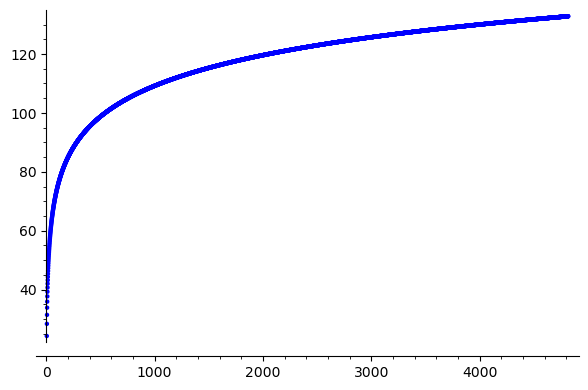

In [6]:
# interpolating polynomials
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)

r2 = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
r2s=pickle.load(r2)
r2.close()
s2=stripQuotationMarks(r2s)

r3 = open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd deltaDagger2Strike series
r3s=pickle.load(r3)
r3.close()
s3=stripQuotationMarks(r3s)

r4 =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4)
r4.close()
s4=stripQuotationMarks(r4s)

s=s1+s2+s3+s4 

data=[]
more=[]
less=[]
same=[]
sign2plus=[]
sign2zero=[]
sign2minus=[]
sign3plus=[]
sign3zero=[]
sign3minus=[]
sign6plus=[]
sign6zero=[]
sign6minus=[]

for k in [0..len(s)-1]:
    m=s[k][0]
    poly=s[k][1]/(m^3*2^6)
    pc2=polynomialCoefficient(2,poly)
    if pc2>0:sign2plus=sign2plus+[m]
    if pc2==0:sign2zero=sign2zero+[m]
    if pc2<0:sign2minus=sign2minus+[m]
    
    pc3=polynomialCoefficient(3,poly)
    if pc3>0:sign3plus=sign3plus+[m]
    if pc3==0:sign3zero=sign3zero+[m]
    if pc3<0:sign3minus=sign3minus+[m]
    
    pc6=polynomialCoefficient(6,poly)
    if pc6>0:sign6plus=sign6plus+[m]
    if pc6==0:sign6zero=sign6zero+[m]
    if pc6<0:sign6minus=sign6minus+[m]
    
    diff=pc2*pc3-pc6
    if diff>0:more=more+[m]
    if diff==0:same=same+[m]
    if diff<0:less=less+[m]
    if diff!=0:data=data+[(m,log(abs(diff)))]
print("more: ",len(more)," less: ",len(less)," same: ",len(same))
print([len(sign2minus),len(sign2zero),len(sign2plus)])
print([len(sign3minus),len(sign3zero),len(sign3plus)])
print([len(sign6minus),len(sign6zero),len(sign6plus)])
print(sign3minus)
plot=list_plot(data)
show(plot)

more:  0  less:  4815  same:  1


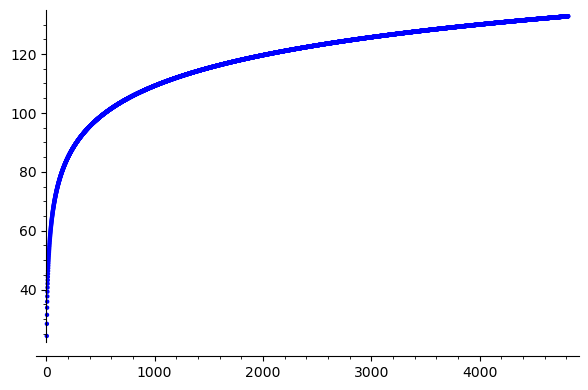

In [4]:
# interpolating polynomials
import pickle
r1 =open('/Users/barrybrent/13sept22no2.txt','rb') # 1st deltaDagger2Strike series
r1s=pickle.load(r1)
r1.close()
s1=stripQuotationMarks(r1s)

r2 = open('/Users/barrybrent/14sept22no1.txt','rb') # 2nd deltaDagger2Strike series
r2s=pickle.load(r2)
r2.close()
s2=stripQuotationMarks(r2s)

r3 = open('/Users/barrybrent/14sept22no2.txt','rb') # 3rd deltaDagger2Strike series
r3s=pickle.load(r3)
r3.close()
s3=stripQuotationMarks(r3s)

r4 =open('/Users/barrybrent/14sept22no3.txt','rb') # 4th deltaDagger2Strike series
r4s=pickle.load(r4)
r4.close()
s4=stripQuotationMarks(r4s)

s=s1+s2+s3+s4 

data=[]
more=[]
less=[]
same=[]

for k in [0..len(s)-1]:
    m=s[k][0]
    poly=s[k][1]/(m^3*2^6)
    pc2=polynomialCoefficient(2,poly)
    
    pc3=polynomialCoefficient(3,poly)
    
    pc6=polynomialCoefficient(6,poly)
    
    diff=abs(pc2*pc3)-abs(pc6)
    if diff>0:more=more+[m]
    if diff==0:same=same+[m]
    if diff<0:less=less+[m]
    if diff!=0:data=data+[(m,log(abs(diff)))]
print("more: ",len(more)," less: ",len(less)," same: ",len(same))
plot=list_plot(data)
show(plot)

In [8]:
poly=D(3*x^2+9*x-12)
print(numericalfactor(poly))

3
